# **Natural Language Processing Twitter Sentiment Analysis on Apple and Google Products**

- Author: Noah Meakins
- Phase: Phase 4 Flex

---

## **Business Understanding**
**Business Problem:** Build an NLP model to analyze Twitter sentiment about Apple and Google products.

**Stakeholder:**
- Consumer Insights Startup:

  - This startup specializes in analyzing social media sentiment and providing actionable insights to clients in the tech industry, including Apple and Google.
  - Clients: Companies, investors, or analysts looking to understand brand performance and market trends for Apple and Google products.

---

## **Data**
The dataset used in this project was sourced from CrowdFlower via [data.world]([https://](https://data.world/crowdflower/brands-and-product-emotions)). In its raw form, it contains 3 columns and 9,093 rows of supervised data. The sentiment of each tweet was rated by a human. 

---

## **Importing Utilized Libraries, Functions, and Data**

Below I will begin with importing the libraries and functions I think I will most likely end up using. The size of this list will change base on what is needed to accomplish this problem. 

I also imported the raw dataset that will be used for this analysis, and performed some initial exploratory data analysis of the dataset itself.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
import keras
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.dummy import DummyClassifier
from collections import Counter
import networkx as nx
from wordcloud import WordCloud 

# Importing specific functions from sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Importing specific functions from matplotlib
from matplotlib.ticker import FixedLocator


# Importing raw data
df = pd.read_csv('../Twitter-Sentiment-Analysis/data/raw/Brands and Product Emotions.csv', encoding='ISO-8859-1')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [3]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


---

## **Pre-Processing**

### **Removing Usernames, Hashtags, and Hyperlinks from the Dataset**

To clean the dataset and prepare it for analysis, usernames, hashtags, and hyperlinks are removed from the text data using regular expressions (`regex`). These elements are typically irrelevant to sentiment analysis and may introduce noise to the model. Here's a breakdown of the process:

**1. Functions to Remove Unnecessary Text Elements:**
   - `remove_usernames(text)`: Removes Twitter usernames (e.g., `@username`) using the regex pattern `r'@\w+'`.
   - `remove_hashtags(text)`: Removes hashtags (e.g., `#hashtag`) using the regex pattern `r'#\w+'`.
   - `remove_hyperlinks(text)`: Removes hyperlinks (e.g., `http://...`) using the regex pattern `r'http\S+'`.

**2. Applying the Functions to the Dataset:**
   - The functions are applied to the `'tweet_text'` column using `apply`. This ensures that usernames, hashtags, and hyperlinks are replaced with empty strings only in the text column.
   - Additionally, any `{link}` placeholders in the text are replaced with an empty string using `str.replace`.

**3. Cleaning the Entire Dataset:**
   - To ensure no unwanted patterns remain across the entire DataFrame, the functions are applied to all string values using `applymap`.

**4. Dropping Irrelevant Rows:**
   - A specific row (index `9092`) is dropped, as it contains random characters that will not benefit the analysis.

**5. Sanity Check:**
   - After the cleaning steps, the DataFrame (`df`) is printed to verify the changes and confirm that usernames, hashtags, hyperlinks, and placeholders have been successfully removed.

By removing these elements, the dataset is simplified, making it more suitable for Natural Language Processing (NLP) tasks such as sentiment analysis.

In [4]:
# Removing usernames, hashtags, and hyperlinks
def remove_usernames(text):
    # replaces usernames with an empty string using regex
    return re.sub(r'@\w+', '', text)

def remove_hashtags(text):
    # replaces hashtags with an empty string using regex
    return re.sub(r'#\w+', '', text)

def remove_hyperlinks(text):
    # replaces hyperlinks with an empty string using regex
    return re.sub(r'http\S+', '', text)

# Applying the functions to the 'tweet_text' column of the original DataFrame using the apply function
df['tweet_text'] = df['tweet_text'].apply(lambda x: remove_usernames(x) if isinstance(x, str) else x)
df['tweet_text'] = df['tweet_text'].apply(lambda x: remove_hashtags(x) if isinstance(x, str) else x)
df['tweet_text'] = df['tweet_text'].apply(lambda x: remove_hyperlinks(x) if isinstance(x, str) else x)
df['tweet_text'] = df['tweet_text'].apply(lambda x: str(x).replace('{link}',''))

# Applying the functions to the entire DataFrame using the applymap function
df = df.map(lambda x: remove_usernames(x) if isinstance(x, str) else x)
df = df.map(lambda x: remove_hashtags(x) if isinstance(x, str) else x)
df = df.map(lambda x: remove_hyperlinks(x) if isinstance(x, str) else x)

df.drop(9092, axis =0, inplace = True)

# Sanity check to see if the functions worked
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,. I have a 3G iPhone. After 3 hrs tweeting at ...,iPhone,Negative emotion
1,Know about ? Awesome iPad/iPhone app that yo...,iPad or iPhone App,Positive emotion
2,Can not wait for 2 also. They should sale th...,iPad,Positive emotion
3,I hope this year's festival isn't as crashy a...,iPad or iPhone App,Negative emotion
4,"great stuff on Fri : Marissa Mayer (Google), ...",Google,Positive emotion
...,...,...,...
9087,"Yup, but I don't have a third app yet. I'm on...",NaN,No emotion toward brand or product
9088,Ipad everywhere.,iPad,Positive emotion
9089,"Wave, buzz... RT We interrupt your regularly ...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product


---

### **Formatting Columns and Handling Missing Values**

In [5]:
# Renaming columns
df = df.rename(columns={
    'tweet_text': 'tweet',
    'emotion_in_tweet_is_directed_at': 'product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'
})

In [6]:
# Creating a list of unique products
product_list = df['product'].unique().tolist()
print(product_list)

['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android', 'Apple', 'Android App', 'Other Google product or service', 'Other Apple product or service']


In [7]:
# Creating a list of unique sentiments
product_list = df['sentiment'].unique().tolist()
print(product_list)

['Negative emotion', 'Positive emotion', 'No emotion toward brand or product', "I can't tell"]


In [8]:
# Creating a boolean DataFrame
nan_df = df.isna()

# Determining the number of missing values in each column
cols_with_nan = nan_df.any()
print(cols_with_nan)

tweet        False
product       True
sentiment    False
dtype: bool


In [9]:
# Replacing NaN values in 'product' column with 'none'
df['product'] = df['product'].fillna('none')

# Dropping rows with NaN values in 'tweet' column
df = df.dropna(subset=['tweet'])

In [10]:
# Checking sentiment counts
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

sentiment
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64


---

### **Formatting Sentiment Values**

In [11]:
# Replacing sentiment values with more readable values
df['sentiment'] = df['sentiment'].replace({
    'Negative emotion': 'negative',
    'Positive emotion': 'positive',
    "I can't tell": 'neutral',
    'No emotion toward brand or product': 'neutral'
})

print(df.head())

                                               tweet             product  \
0  . I have a 3G iPhone. After 3 hrs tweeting at ...              iPhone   
1   Know about  ? Awesome iPad/iPhone app that yo...  iPad or iPhone App   
2   Can not wait for  2 also. They should sale th...                iPad   
3   I hope this year's festival isn't as crashy a...  iPad or iPhone App   
4   great stuff on Fri : Marissa Mayer (Google), ...              Google   

  sentiment  
0  negative  
1  positive  
2  positive  
3  negative  
4  positive  


---

### **Changing Sentiment Values to Numerical Values**

In [12]:
# Setting sentiment column to numerical values
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}

# Mapping the sentiment values to numerical values using the map function
df['sentiment'] = df['sentiment'].map(sentiment_mapping)
df

,tweet,product,sentiment
0,. I have a 3G iPhone. After 3 hrs tweeting at ...,iPhone,-1
1,Know about ? Awesome iPad/iPhone app that yo...,iPad or iPhone App,1
2,Can not wait for 2 also. They should sale th...,iPad,1
3,I hope this year's festival isn't as crashy a...,iPad or iPhone App,-1
4,"great stuff on Fri : Marissa Mayer (Google), ...",Google,1
...,...,...,...
9087,"Yup, but I don't have a third app yet. I'm on...",none,0
9088,Ipad everywhere.,iPad,1
9089,"Wave, buzz... RT We interrupt your regularly ...",none,0
9090,"Google's Zeiger, a physician never reported po...",none,0


In [13]:
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

sentiment
 0    5544
 1    2978
-1     570
Name: count, dtype: int64


In [14]:
# Creating a copy of the DataFrame
df2 = df.copy()

---

## **Text Preprocessing for NLP Analysis**

The following steps preprocess the text data in the `tweet` column of the dataset (`df2`) to prepare it for Natural Language Processing (NLP) tasks. This includes removing unwanted characters, tokenizing, and normalizing the text. Here's an explanation of each step:


**1. Removing Punctuation**
- Punctuation marks are removed using Python's `string` module.
- The `str.translate` method is used with `str.maketrans` to remove all punctuation from the text.
- This step ensures that punctuation marks like `!`, `?`, and `.` do not interfere with tokenization or model training.

**2. Removing Special Characters**
- Any remaining special characters `(e.g., @, #)` are removed using regular expressions `(\W+)`.
- This replaces sequences of non-word characters with a single space, simplifying the text.

**3. Converting to Lowercase**
- All text is converted to lowercase using the `.str.lower()` method.
- This ensures uniformity in the text and avoids treating Word and word as different tokens.

**4. Tokenizing Text**
- The text in the tweet column is split into individual words (tokens) using `nltk.word_tokenize`.
- This step prepares the text for further processing, such as removing stopwords and lemmatization.

**5. Removing Stopwords**
- Stopwords `(e.g., “and”, “the”, “is”)` are removed using NLTK’s built-in list of English stopwords.
- The tokens column is updated to exclude these words, reducing noise in the data.

**6. Lemmatization**
- Tokens are lemmatized using `NLTK’s WordNetLemmatizer`.
- Lemmatization reduces words to their base or root form (e.g., “running” → “run”), ensuring consistency across word variants.

In [15]:
# Removing punctuation marks using string module
df2['tweet'] = df2['tweet'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)) if type(x)==str else x)

# Removing special characters using regex
df2['tweet'] = df2['tweet'].apply(lambda x: re.sub(r'\W+', ' ', x) if type(x)==str else x)

# Converting 'tweet' column to lowercase
df2['tweet'] = df2['tweet'].str.lower()

# Tokenizing the 'tweet' column
df2['tokens'] = df2['tweet'].apply(lambda x: nltk.word_tokenize(x) if type(x)==str else x)

# Removing stopwords from the 'tokens' column
stop_words = set(stopwords.words('english'))
df2['tokens'] = df2['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words] if type(x)==list else x)

# Lemmatizing the 'tokens' column
lemmatizer = WordNetLemmatizer()
df2['lemmatized'] = df2['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x] if type(x)==list else x)

df2

,tweet,product,sentiment,tokens,lemmatized
0,i have a 3g iphone after 3 hrs tweeting at it...,iPhone,-1,"[3g, iphone, 3, hrs, tweeting, dead, need, upg...","[3g, iphone, 3, hr, tweeting, dead, need, upgr..."
1,know about awesome ipadiphone app that youll ...,iPad or iPhone App,1,"[know, awesome, ipadiphone, app, youll, likely...","[know, awesome, ipadiphone, app, youll, likely..."
2,can not wait for 2 also they should sale them...,iPad,1,"[wait, 2, also, sale]","[wait, 2, also, sale]"
3,i hope this years festival isnt as crashy as ...,iPad or iPhone App,-1,"[hope, years, festival, isnt, crashy, years, i...","[hope, year, festival, isnt, crashy, year, iph..."
4,great stuff on fri marissa mayer google tim o...,Google,1,"[great, stuff, fri, marissa, mayer, google, ti...","[great, stuff, fri, marissa, mayer, google, ti..."
...,...,...,...,...,...
9087,yup but i dont have a third app yet im on and...,none,0,"[yup, dont, third, app, yet, im, android, sugg...","[yup, dont, third, app, yet, im, android, sugg..."
9088,ipad everywhere,iPad,1,"[ipad, everywhere]","[ipad, everywhere]"
9089,wave buzz rt we interrupt your regularly sched...,none,0,"[wave, buzz, rt, interrupt, regularly, schedul...","[wave, buzz, rt, interrupt, regularly, schedul..."
9090,googles zeiger a physician never reported pote...,none,0,"[googles, zeiger, physician, never, reported, ...","[google, zeiger, physician, never, reported, p..."


---

### **Combining and Cleaning Text for Frequency Analysis**

This section of the code focuses on combining all the tweets in the dataset into a single text corpus, analyzing word frequencies, and removing rare words to clean the data further. Here's a breakdown of each step:

**1. Combining All Tweets**
- All the tweets in the `tweet` column are combined into a single string using Python's `.join()` method.
- This creates a large text corpus that can be analyzed as a whole.

**2. Tokenizing the Text**
- The combined text is tokenized into individual words using nltk.tokenize.word_tokenize.
- Tokenization splits the text into smaller units (words) for frequency analysis.

**3. Calculating Word Frequencies**
- A frequency distribution of the tokens is calculated using NLTK’s FreqDist.
- This helps identify how often each word appears in the corpus.

**4. Removing Rare Words**
- A minimum frequency threshold is defined (min_freq = 5) to filter out words that appear too infrequently.
- Rare words are removed from the text corpus, as they may add noise to the data without contributing significant information.

In [16]:
# Combining all tweets into a single string
text = " ".join(tweet for tweet in df2['tweet'])

# Tokenizing the text
words = nltk.tokenize.word_tokenize(text)

# Creating a frequency distribution of words
freq_dist = FreqDist(words)

# Plotting the frequency distribution
min_freq = 5

# Filtering out words with frequency less than min_freq
clean_text = " ".join(word for word in words if freq_dist[word] > min_freq)

In [17]:
# Creating another copy of the DataFrame
df3 = df2.copy()

---

## Post Processing EDA With Supporting Visualizations

In [18]:
# Converting sentiment to numeric
df3['sentiment'] = pd.to_numeric(df3['sentiment'], errors='coerce')

# Calculating the mean sentiment for each product
sentiment_by_product = df3.groupby('product')['sentiment'].mean()

# Sorting the mean sentiment values in descending order
sentiment_by_product = sentiment_by_product.sort_values(ascending=False)
print(sentiment_by_product)

product
Other Apple product or service     0.857143
Android App                        0.790123
Android                            0.782051
iPad or iPhone App                 0.710638
iPad                               0.706131
Apple                              0.677761
Google                             0.646512
Other Google product or service    0.645051
iPhone                             0.272727
none                               0.043958
Name: sentiment, dtype: float64


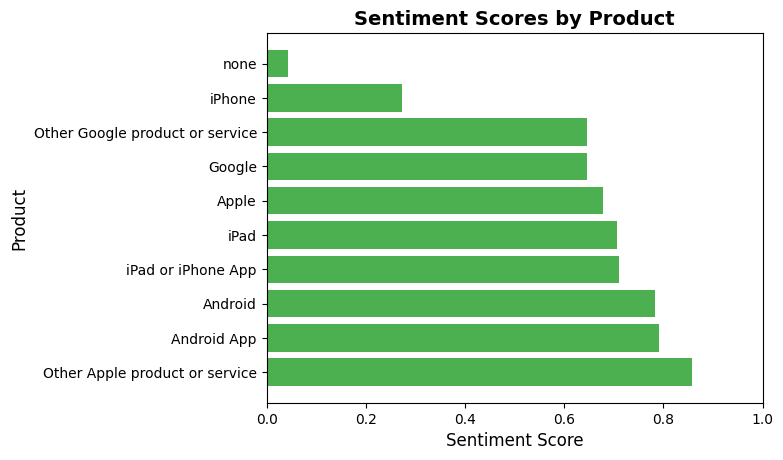

<Figure size 640x480 with 0 Axes>

In [19]:
# Plotting the sentiment scores by product
plt.barh(sentiment_by_product.index, sentiment_by_product.values, color='#4CAF50')

# Setting the x-axis limits to 0 and 1
plt.xlim(0, 1)

plt.title('Sentiment Scores by Product', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Product', fontsize=12)

plt.show()

plt.savefig("../Twitter-Sentiment-Analysis/images/Sentiment-Scores-by-Product.png", dpi=300, bbox_inches='tight')

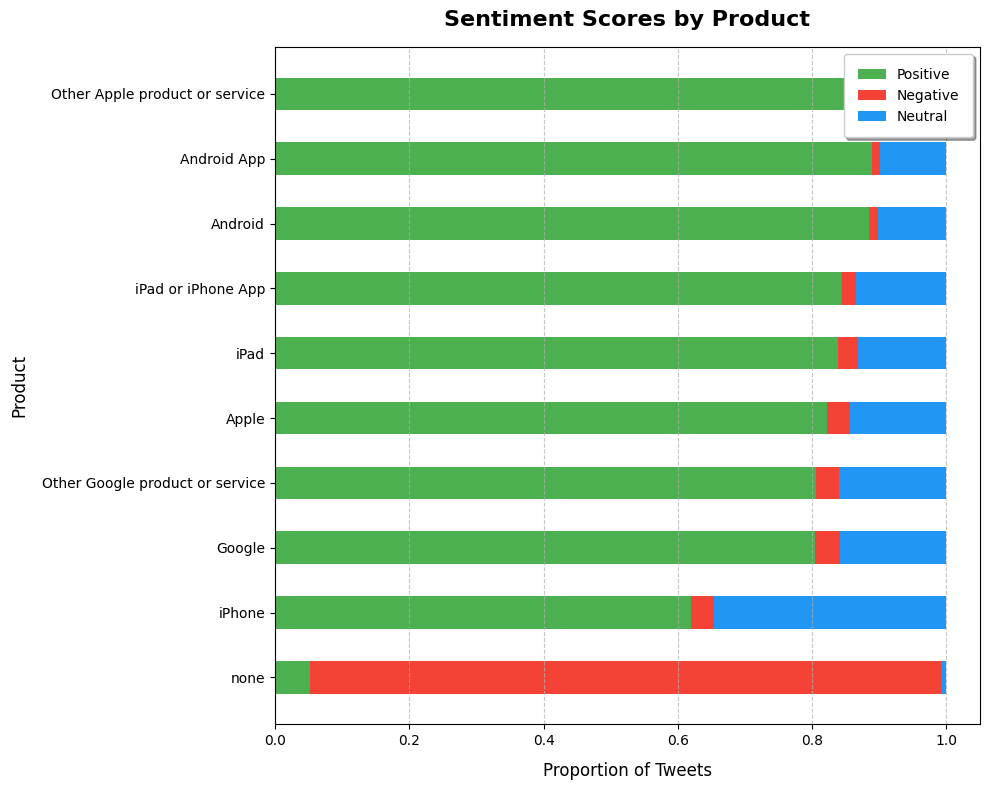

<Figure size 640x480 with 0 Axes>

In [20]:
# Calculating the sentiment counts for each product
sentiment_counts = df3.groupby(['product', 'sentiment']).size().unstack(fill_value=0)

# Calculating the proportion of each sentiment for each product
sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Sorting the products by the proportion of positive sentiment
sentiment_by_product = sentiment_proportions[1].sort_values(ascending=True)

# Plotting the sentiment proportions by product
fig, ax = plt.subplots(figsize=(10, 8))
ind = np.arange(len(sentiment_proportions.index))
width = 0.5

positive_color = '#4CAF50'
negative_color = '#F44336'
neutral_color = '#2196F3'

# Plotting the bars
p1 = ax.barh(ind, sentiment_proportions[1][sentiment_by_product.index], width, color=positive_color, label='Positive')
p2 = ax.barh(ind, sentiment_proportions[0][sentiment_by_product.index], width, 
             left=sentiment_proportions[1][sentiment_by_product.index], color=negative_color, label='Negative')
p3 = ax.barh(ind, sentiment_proportions[-1][sentiment_by_product.index], width, 
             left=sentiment_proportions[1][sentiment_by_product.index] + sentiment_proportions[0][sentiment_by_product.index], color=neutral_color, label='Neutral')

ax.legend(loc='upper right', fontsize=10, frameon=True, shadow=True, borderpad=1)

ax.set_title('Sentiment Scores by Product', fontsize=16, fontweight='bold', pad=15)
ax.set_yticks(ind)
ax.set_yticklabels(sentiment_by_product.index, fontsize=10)
ax.set_xlabel('Proportion of Tweets', fontsize=12, labelpad=10)
ax.set_ylabel('Product', fontsize=12, labelpad=10)

ax.xaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

plt.savefig("../Twitter-Sentiment-Analysis/images/Sentiment-Scores-by-Product-v2.png", dpi=300, bbox_inches='tight')

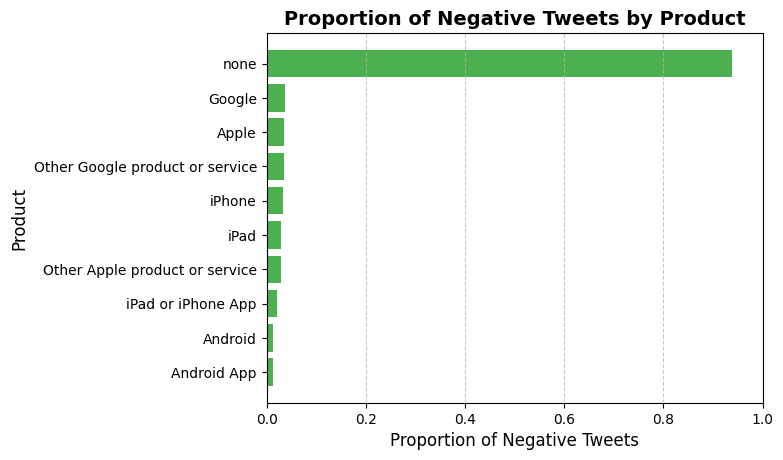

<Figure size 640x480 with 0 Axes>

In [21]:
# Calculating number of negative sentiment tweets for each product
negative_counts = df3[df3['sentiment'] == 0].groupby('product').size()

# Calculating the proportion of negative sentiment tweets for each product
negative_proportions = negative_counts / df3.groupby('product').size()

# Sorting the products by the proportion of negative sentiment
negative_proportions = negative_proportions.sort_values()

# Plotting the proportion of negative sentiment tweets by product
fig, ax = plt.subplots()
ax.barh(negative_proportions.index, negative_proportions.values, color='#4CAF50')

ax.xaxis.grid(True, linestyle='--', alpha=0.7)

plt.xlim(0, 1)

plt.title('Proportion of Negative Tweets by Product', fontsize=14, fontweight='bold')
plt.xlabel('Proportion of Negative Tweets', fontsize=12)
plt.ylabel('Product', fontsize=12)

plt.show()

plt.savefig("../Twitter-Sentiment-Analysis/images/Proportion-of-Negative-Tweets-by-Product.png", dpi=300, bbox_inches='tight')

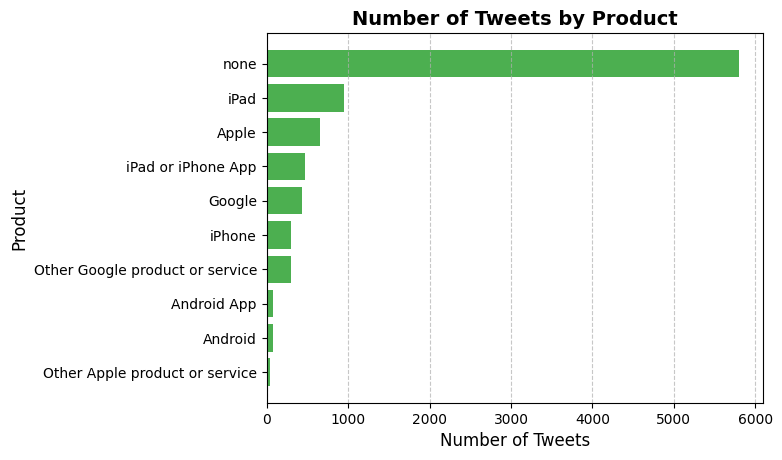

<Figure size 640x480 with 0 Axes>

In [22]:
# Calculating the number of tweets for each product
tweet_counts = df3.groupby('product').size()

# Sorting the products by the number of tweets
tweet_counts = tweet_counts.sort_values()

# Plotting the number of tweets by product
fig, ax = plt.subplots()
ax.barh(tweet_counts.index, tweet_counts.values, color='#4CAF50')

ax.xaxis.grid(True, linestyle='--', alpha=0.7)

plt.title('Number of Tweets by Product', fontsize=14, fontweight='bold')
plt.xlabel('Number of Tweets', fontsize=12)
plt.ylabel('Product', fontsize=12)

plt.show()

plt.savefig("../Twitter-Sentiment-Analysis/images/Number-of-Tweets-by-Product.png", dpi=300, bbox_inches='tight')

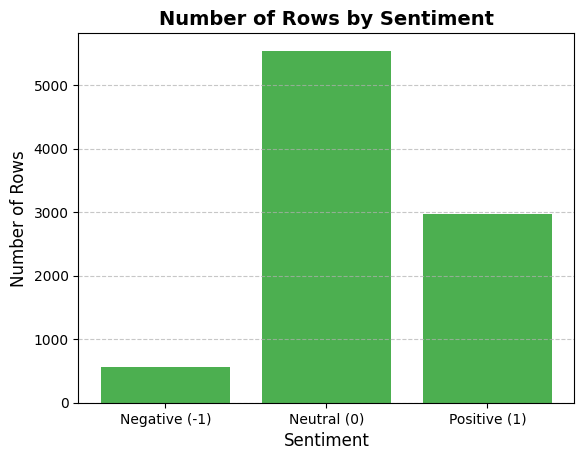

<Figure size 640x480 with 0 Axes>

In [23]:
# Calculating the number of tweets for each sentiment
sentiment_counts = df3.groupby('sentiment').size()

# Plotting the number of tweets by sentiment
fig, ax = plt.subplots()
ax.bar(sentiment_counts.index, sentiment_counts.values, color='#4CAF50')
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(['Negative (-1)', 'Neutral (0)', 'Positive (1)'])

ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.title('Number of Rows by Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Rows', fontsize=12)

plt.show()

plt.savefig("../Twitter-Sentiment-Analysis/images/Number-of-Rows-by-Sentiment.png", dpi=300, bbox_inches='tight')

---

## **Modeling**

### **Initial Baseline Model**

In [24]:
# Creating a pipeline with Logistic Regression as the classifier and CountVectorizer as the vectorizer
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression())
])

# Splitting the data into training and testing sets
X = df3['tweet']
y = df3['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# Calculating the accuracy of the model
accuracy = pipeline.score(X_test, y_test)
print("Test Accuracy:", accuracy)
train_accuracy = pipeline.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)

Test Accuracy: 0.6844420010995053
Train Accuracy: 0.9114533205004812


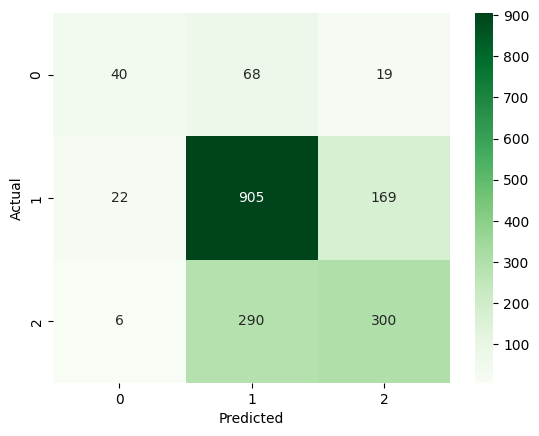

,precision,recall,f1-score,support
-1,0.588235,0.314961,0.410256,127.000000
0,0.716548,0.825730,0.767274,1096.000000
1,0.614754,0.503356,0.553506,596.000000
accuracy,0.684442,0.684442,0.684442,0.684442
macro avg,0.639846,0.548015,0.577012,1819.000000
weighted avg,0.674236,0.684442,0.672306,1819.000000


<Figure size 640x480 with 0 Axes>

In [25]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

plt.savefig("../Twitter-Sentiment-Analysis/images/baseline-model-heatmap.png", dpi=300, bbox_inches='tight')

# Generating the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Converting the report to a DataFrame
scores_df = pd.DataFrame(report).transpose()

scores_df

---

### **First Run**

In [26]:
# Defining X and y variables for the model
X = df3['tweet'].values
y = df3['sentiment'].values

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Undersampling the majority class using RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')

# Resampling the training data
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train.reshape(-1, 1), y_train)

# Creating a pipeline with CountVectorizer as the vectorizer, RandomUnderSampler as the sampling method, and Logistic Regression as the classifier
pipeline = ImbPipeline([
    ('vectorizer', CountVectorizer()),
    ('sampling', RandomOverSampler(random_state=42)),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

# Fitting the pipeline to the resampled training data
pipeline.fit(X_train_resampled.squeeze(), y_train_resampled)

# Making predictions on the test data
y_pred = pipeline.predict(X_test)

# Calculating the accuracy of the model
accuracy = pipeline.score(X_test, y_test)
print("Test Accuracy:", accuracy)
train_accuracy = pipeline.score(X_train_resampled.squeeze(), y_train_resampled)
print("Train Accuracy:", train_accuracy)

/Users/unknown1/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/unknown1/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/unknown1/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/Users/unknown1/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/unknown1/

Test Accuracy: 0.5162177020340847
Train Accuracy: 0.9629742962056304


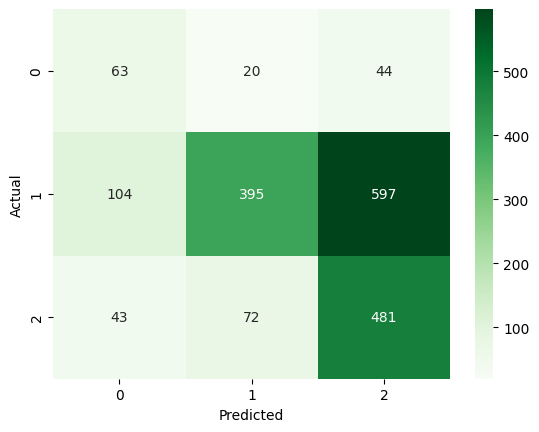

,precision,recall,f1-score,support
-1,0.300000,0.496063,0.373887,127.000000
0,0.811088,0.360401,0.499052,1096.000000
1,0.428699,0.807047,0.559953,596.000000
accuracy,0.516218,0.516218,0.516218,0.516218
macro avg,0.513262,0.554504,0.477631,1819.000000
weighted avg,0.650114,0.516218,0.510268,1819.000000


<Figure size 640x480 with 0 Axes>

In [27]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

plt.savefig("../Twitter-Sentiment-Analysis/images/model-first-run-heatmap.png", dpi=300, bbox_inches='tight')

# Generating the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Converting the report to a DataFrame
scores_df = pd.DataFrame(report).transpose()

scores_df

---

### **Second Run**

In [28]:
# Defining X and y variables for the model
X = df3['tweet'].values
y = df3['sentiment'].values

# Oversampling with the sampling strategy set to 'auto'
oversample = RandomOverSampler(sampling_strategy='auto')

# Reshaping the input data
X = X.reshape(-1, 1)

# Resampling the data using RandomOverSampler
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Reshaping the resampled data
X_resampled = X_resampled.reshape(-1)

# Tokenizing the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_resampled)
X_seq = tokenizer.texts_to_sequences(X_resampled)
X_pad = pad_sequences(X_seq, maxlen=100)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_resampled, test_size=0.2, random_state=42)

# Defining the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=100))
model.add(Conv1D(64, 9, activation='relu'))
model.add(Dropout(0.8))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(32, 9, activation='relu'))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Converting the target variable to categorical
y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

# Fitting the model to the training data
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Training and validation accuracy
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy:', train_acc)

# Testing accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy:', test_acc)

/Users/unknown1/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/unknown1/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/unknown1/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Epoch 1/10


/Users/unknown1/anaconda3/envs/learn-env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4211 - loss: 1.0418 - val_accuracy: 0.6886 - val_loss: 0.7507
Epoch 2/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7525 - loss: 0.5673 - val_accuracy: 0.8022 - val_loss: 0.5893
Epoch 3/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8509 - loss: 0.3980 - val_accuracy: 0.8302 - val_loss: 0.4824
Epoch 4/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8835 - loss: 0.3023 - val_accuracy: 0.8299 - val_loss: 0.4551
Epoch 5/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9019 - loss: 0.2572 - val_accuracy: 0.8341 - val_loss: 0.4292
Epoch 6/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9102 - loss: 0.2346 - val_accuracy: 0.8356 - val_loss: 0.4191
Epoch 7/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9163 - loss: 0.2185 - val_accuracy: 0.8419 - val_loss: 0.4121
Epoch 8/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9244 - loss: 0.1898 - val_accuracy: 0.841

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

    negative       0.76      0.75      0.75      1087
     neutral       0.79      0.77      0.78      1140
    positive       0.95      0.99      0.97      1100

    accuracy                           0.84      3327
   macro avg       0.83      0.84      0.84      3327
weighted avg       0.83      0.84      0.84      3327



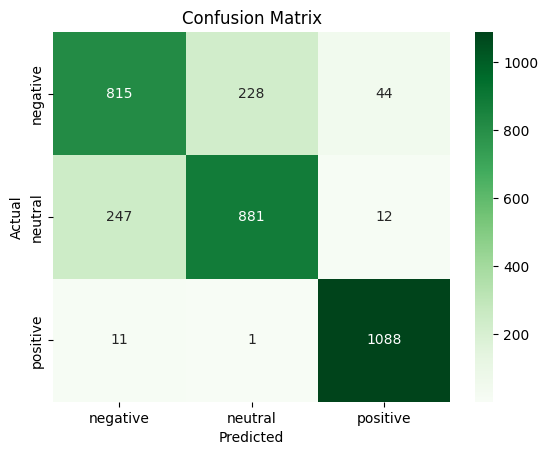

In [29]:
# Predicting the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Generating the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plotting the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.savefig("../Twitter-Sentiment-Analysis/images/model-second-run-heatmap.png", dpi=300, bbox_inches='tight')

print(classification_report(y_test_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive']))

---

### **Third Run**

In [30]:
# Defining the X and y variables
X = df3['tweet'].values
y = df3['sentiment'].values

# Oversampling the data using RandomOverSampler with the sampling strategy set to 'auto'
oversample = RandomOverSampler(sampling_strategy='auto')

# Reshape the input data
X = X.reshape(-1, 1)

# Resample the data
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Reshape the resampled data
X_resampled = X_resampled.reshape(-1)

# Tokenizing the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_resampled)
X_seq = tokenizer.texts_to_sequences(X_resampled)
X_pad = pad_sequences(X_seq, maxlen=100)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_resampled, test_size=0.2, random_state=42)

# Defining the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=100))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='softmax'))

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Converting the target variable to categorical
y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

# Fitting the model to the training data
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Training and validation accuracy
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy:', train_acc)

# Testing accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy:', test_acc)

/Users/unknown1/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/unknown1/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/unknown1/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Epoch 1/10


/Users/unknown1/anaconda3/envs/learn-env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5525 - loss: 0.8831 - val_accuracy: 0.7980 - val_loss: 0.4444
Epoch 2/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8837 - loss: 0.2973 - val_accuracy: 0.8470 - val_loss: 0.3686
Epoch 3/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9394 - loss: 0.1713 - val_accuracy: 0.8578 - val_loss: 0.3517
Epoch 4/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9519 - loss: 0.1335 - val_accuracy: 0.8524 - val_loss: 0.3940
Epoch 5/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9666 - loss: 0.0896 - val_accuracy: 0.8581 - val_loss: 0.3926
Epoch 6/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9751 - loss: 0.0662 - val_accuracy: 0.8708 - val_loss: 0.4287
Epoch 7/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9830 - loss: 0.0523 - val_accuracy: 0.8671 - val_loss: 0.4388
Epoch 8/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9858 - loss: 0.0382 - val_accuracy: 0.8656 - val_

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

    negative       0.80      0.83      0.82      1087
     neutral       0.86      0.80      0.83      1140
    positive       0.95      1.00      0.98      1100

    accuracy                           0.87      3327
   macro avg       0.87      0.87      0.87      3327
weighted avg       0.87      0.87      0.87      3327



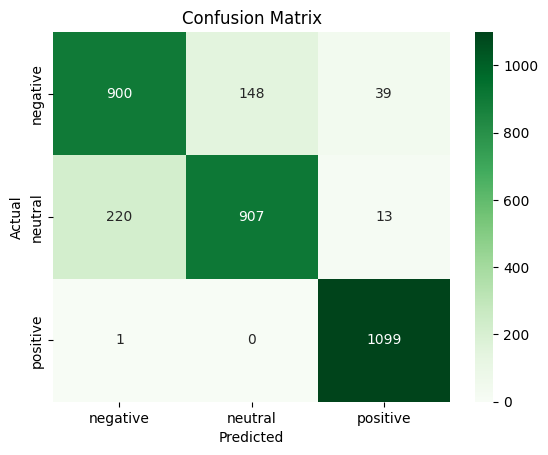

In [31]:
# Predicting the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Generating the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plotting the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.savefig("../Twitter-Sentiment-Analysis/images/model-third-run-heatmap.png", dpi=300, bbox_inches='tight')

print(classification_report(y_test_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive']))

---

### **Fourth Run**

In [32]:
# Defining the X and y variables
X = df3['tweet'].values
y = df3['sentiment'].values

# Oversampling the data using RandomOverSampler with the sampling strategy set to 'auto'
oversample = RandomOverSampler(sampling_strategy='auto')

# Reshape the input data
X = X.reshape(-1, 1)

# Resample the data
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Reshape the resampled data
X_resampled = X_resampled.reshape(-1)

# Tokenizing the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_resampled)
X_seq = tokenizer.texts_to_sequences(X_resampled)
X_pad = pad_sequences(X_seq, maxlen=100)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_resampled, test_size=0.2, random_state=42)

# Defining the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=100))
model.add(Conv1D(64, 5, activation='relu'))
model.add(Dropout(0.8))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(32, 5, activation='relu'))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='softmax'))

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Converting the target variable to categorical
y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

# Fitting the model to the training data
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Training and validation accuracy
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy:', train_acc)

# Testing accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy:', test_acc)

/Users/unknown1/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/unknown1/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/unknown1/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Epoch 1/10


/Users/unknown1/anaconda3/envs/learn-env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4297 - loss: 1.0213 - val_accuracy: 0.7385 - val_loss: 0.7530
Epoch 2/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7562 - loss: 0.5360 - val_accuracy: 0.8170 - val_loss: 0.5685
Epoch 3/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8584 - loss: 0.3620 - val_accuracy: 0.8209 - val_loss: 0.5059
Epoch 4/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8891 - loss: 0.2848 - val_accuracy: 0.8302 - val_loss: 0.4644
Epoch 5/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9072 - loss: 0.2468 - val_accuracy: 0.8302 - val_loss: 0.4434
Epoch 6/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9147 - loss: 0.2200 - val_accuracy: 0.8413 - val_loss: 0.4101
Epoch 7/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9249 - loss: 0.1921 - val_accuracy: 0.8503 - val_loss: 0.4066
Epoch 8/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9310 - loss: 0.1720 - val_accuracy: 0.843

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

    negative       0.80      0.71      0.75      1087
     neutral       0.79      0.81      0.80      1140
    positive       0.92      1.00      0.96      1100

    accuracy                           0.84      3327
   macro avg       0.84      0.84      0.84      3327
weighted avg       0.84      0.84      0.84      3327



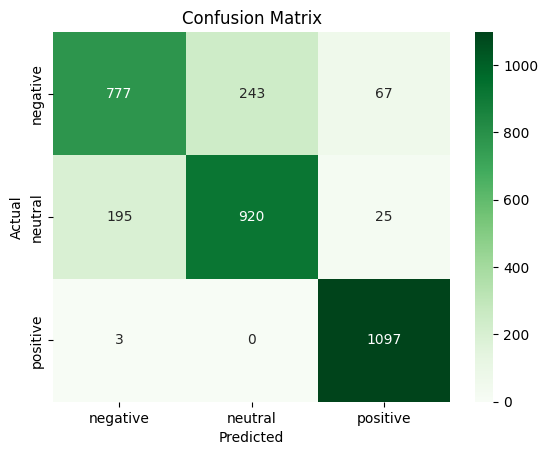

In [33]:
# Predicting the probabilities of each class
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Generating a confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plotting the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.savefig("../Twitter-Sentiment-Analysis/images/model-fourth-run-heatmap.png", dpi=300, bbox_inches='tight')

print(classification_report(y_test_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive']))

---

## **Evaluating Strengths and Weaknesses**

In [34]:
# Predicting the probabilities for X_test
y_pred_prob = model.predict(X_test)

# Calculating the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

print('ROC AUC Score:', roc_auc)

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ROC AUC Score: 0.9398672420992411


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


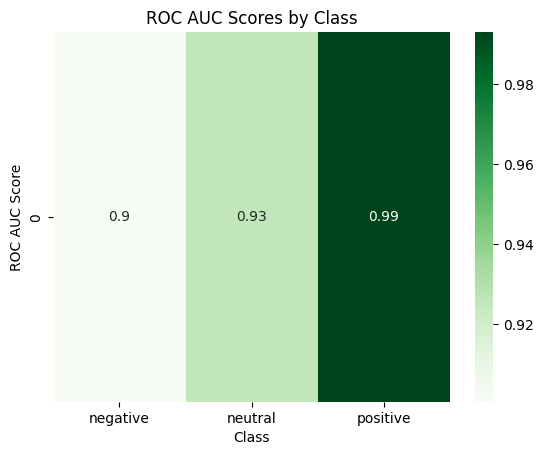

In [35]:
from sklearn.metrics import roc_auc_score

# Predicting the probabilities for X_test
y_pred_prob = model.predict(X_test)

# Calculating the ROC AUC score for each class
roc_auc_scores = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average=None)

# Plotting the ROC AUC scores by class
sns.heatmap([roc_auc_scores], annot=True, cmap='Greens', xticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Class')
plt.ylabel('ROC AUC Score')
plt.title('ROC AUC Scores by Class')
plt.show()

### **Word Cloud**

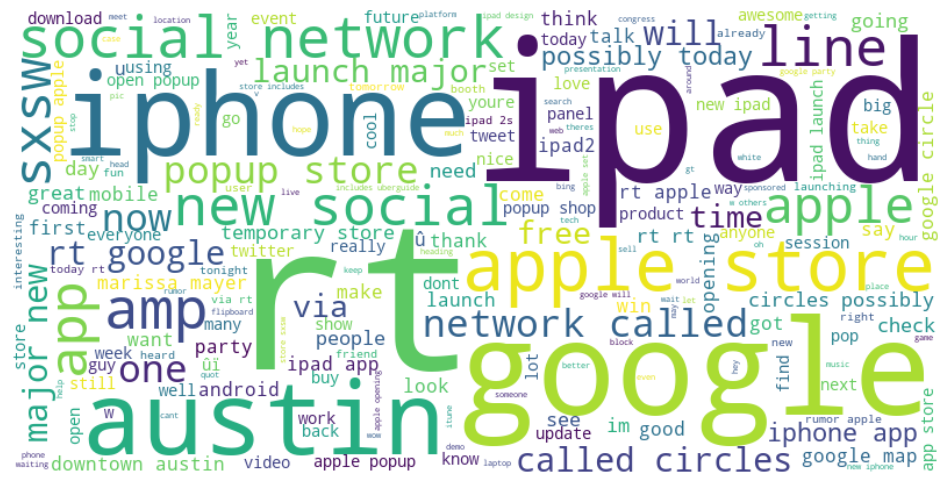

In [36]:
# Joining all tweets into a single string
text = " ".join(review for review in df3['tweet'])

# Generating the wordcloud using the WordCloud function
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)

# Plotting the wordcloud
plt.figure(figsize=(12, 10), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

---

# **Evaluation**